In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

In [81]:
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H

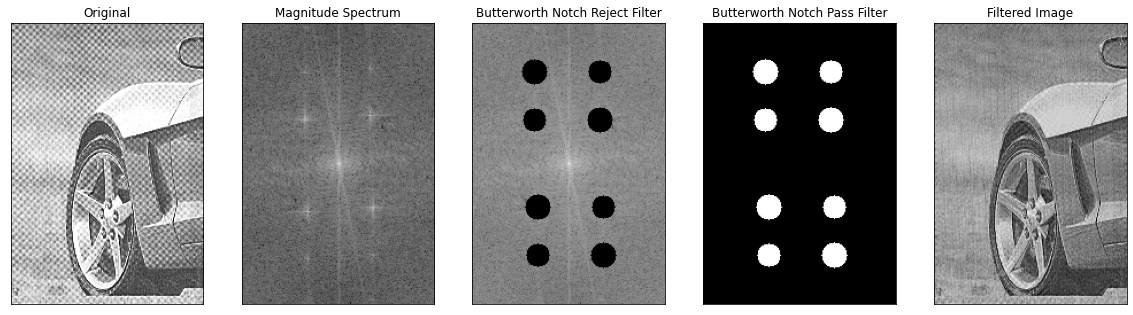

In [129]:
img = cv2.imread('Img-1.tif', 0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

img_shape = img.shape

H1 = notch_reject_filter(img_shape, 10, 38, 30)
H2 = notch_reject_filter(img_shape, 11, -38, 27)
H3 = notch_reject_filter(img_shape, 11, 80, 30)
H4 = notch_reject_filter(img_shape, 10, -80, 27)



NotchFilter = H1*H2*H3*H4
NotchRejectCenter = fshift * NotchFilter 
NotchReject = np.fft.ifftshift(NotchRejectCenter)

NotchPass=1-NotchFilter
# Compute the inverse DFT of the result

inverse_NotchReject = np.fft.ifft2(NotchReject)  

Filtered_Image = np.abs(inverse_NotchReject)

Notch_Regect_Filter=magnitude_spectrum*NotchFilter



f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.subplot(2,5,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,5,2),plt.imshow(magnitude_spectrum,cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(2,5,3),plt.imshow(magnitude_spectrum*NotchFilter, "gray") 
plt.title("Butterworth Notch Reject Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,4),plt.imshow(NotchPass,cmap="gray") 
plt.title("Butterworth Notch Pass Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,5),plt.imshow(Filtered_Image,cmap="gray") 
plt.title("Filtered Image"),plt.xticks([]), plt.yticks([])


plt.show()

In [191]:
def bandreject_filter(shape, d0=160, w=20, n=4):

    P, Q = shape
    # Initialize filter with ones
    H = np.zeros((P, Q))
    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)
            # Define bandreject transfer funtion for each filter type
            if D_uv == d0: # To avoid dividing by zero
                H[u, v] = 0
            else:
                H[u, v] = 1/(1 + ((D_uv*w)/(D_uv**2 - d0**2))**(2*n))

    return H

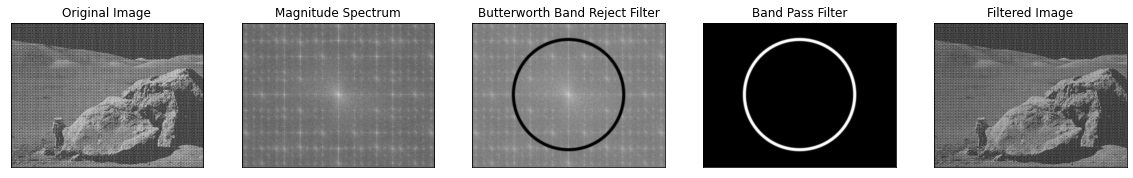

In [209]:
img2 = cv2.imread('Img-2.tif', 0)
M, N = img.shape
P = 2*M
Q = 2*N

# Take the fourier transform of the image, with padding to shape P X Q
F = np.fft.fft2(img, s=(P,Q))

# Shift the low frequencies to the center.
F = np.fft.fftshift(F)

# Get power spectrum of the image
pow_spec = np.abs(F)**2


# H = notch_reject_filter(F.shape, d0, n, u_k, v_k)
H1 = bandreject_filter(F.shape, 360, 20, 4)
H=H1
# Form product of image with filter
G = F * H

# Shift frequencies back
G = np.fft.ifftshift(G)

# Inverse fourier transform to get output image in spatial domain
G = np.fft.ifft2(G)

# Get real values
G = np.abs(G)

# Extract M x N image from top left quadrant
G = G[0:M, 0:N]
BandPass=1-H

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.subplot(2,5,1),plt.imshow(img2,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])


plt.subplot(2,5,2),plt.imshow(np.log(pow_spec),cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(2,5,3),plt.imshow(np.log(pow_spec)*np.abs(H), "gray") 
plt.title("Butterworth Band Reject Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,4),plt.imshow(BandPass, "gray") 
plt.title("Band Pass Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,5),plt.imshow(G,cmap="gray") 
plt.title("Filtered Image"),plt.xticks([]), plt.yticks([])


plt.show()